In [1]:
import kaggle

# Download latest version
kaggle.api.dataset_download_files("vinayakshanawad/cement-manufacturing-concrete-dataset", path='./Data/', unzip=True)

print("Download concluido")

Dataset URL: https://www.kaggle.com/datasets/vinayakshanawad/cement-manufacturing-concrete-dataset
Download concluido


Análise de Correlação de Ingredientes

In [33]:
# Importação das bibliotecas necessárias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_csv("data/concrete.csv")
print(df.head())

   cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0    0.0  228.0           0.0      932.0    670.0   28   
4   154.8  183.4    0.0  193.3           9.1     1047.4    696.7   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29  


In [3]:
# Verificar as correlações entre todas as variáveis, incluindo resistência à compressão
correlation_matrix = df.corr()
print("Matriz de correlação:\n", correlation_matrix)

Matriz de correlação:
                 cement      slag       ash     water  superplastic  coarseagg  \
cement        1.000000 -0.275216 -0.397467 -0.081587      0.092386  -0.109349   
slag         -0.275216  1.000000 -0.323580  0.107252      0.043270  -0.283999   
ash          -0.397467 -0.323580  1.000000 -0.256984      0.377503  -0.009961   
water        -0.081587  0.107252 -0.256984  1.000000     -0.657533  -0.182294   
superplastic  0.092386  0.043270  0.377503 -0.657533      1.000000  -0.265999   
coarseagg    -0.109349 -0.283999 -0.009961 -0.182294     -0.265999   1.000000   
fineagg      -0.222718 -0.281603  0.079108 -0.450661      0.222691  -0.178481   
age           0.081946 -0.044246 -0.154371  0.277618     -0.192700  -0.003016   
strength      0.497832  0.134829 -0.105755 -0.289633      0.366079  -0.164935   

               fineagg       age  strength  
cement       -0.222718  0.081946  0.497832  
slag         -0.281603 -0.044246  0.134829  
ash           0.079108 -0.15437

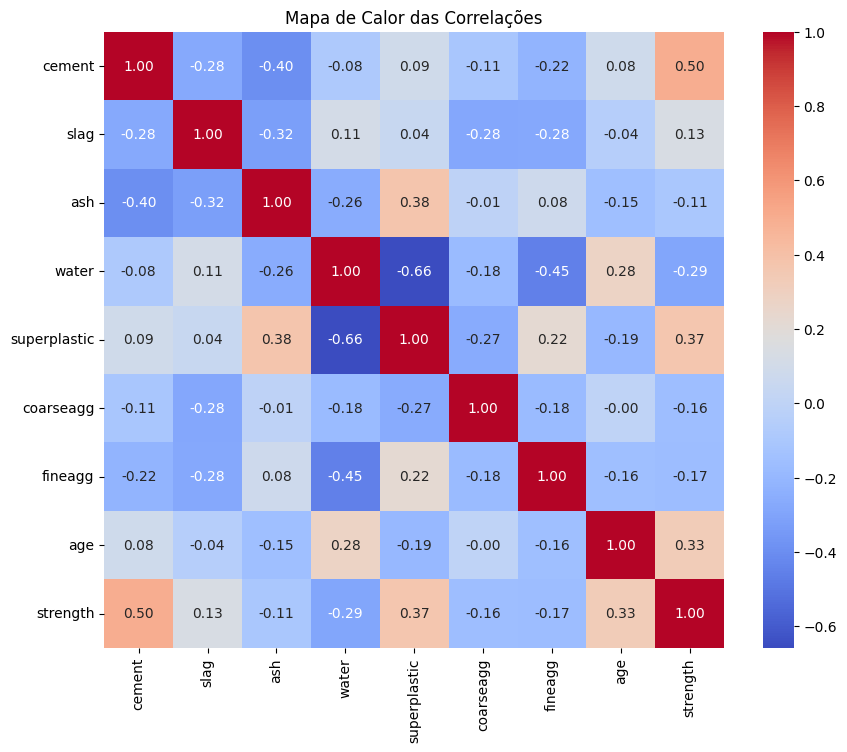

In [4]:
# Plotar o heatmap das correlações
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor das Correlações")
plt.show()

In [ ]:
# Verificar a correlação de cada ingrediente com a resistência à compressão
resistencia = 'strength' 
ingredientes = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']
for ingrediente in ingredientes:
    corr, _ = pearsonr(df[ingrediente], df[resistencia])
    print(f"Correlação entre {ingrediente} e resistência à compressão: {corr:.2f}")


Correlação entre cement e resistência à compressão: 0.50
Correlação entre slag e resistência à compressão: 0.13
Correlação entre ash e resistência à compressão: -0.11
Correlação entre water e resistência à compressão: -0.29
Correlação entre superplastic e resistência à compressão: 0.37
Correlação entre coarseagg e resistência à compressão: -0.16
Correlação entre fineagg e resistência à compressão: -0.17
Correlação entre age e resistência à compressão: 0.33


Os resultados sugerem que:
Cimento e superplastificantes são os principais contribuintes positivos para a resistência à compressão.
Água e os agregados apresentam correlações negativas, o que indica que quantidades excessivas desses materiais podem reduzir a resistência.
Idade de cura tem uma influência positiva significativa, confirmando que o concreto fica mais forte com o tempo.

Modelagem Preditiva da Resistência à Compressão

In [14]:
# Definir as variáveis independentes (ingredientes) e a variável dependente (resistência à compressão)
X = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']]
y = df['strength']


In [24]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Criar o modelo de regressão linear e treiná-lo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [25]:
# Fazer previsões com o conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo usando Mean Squared Error e R-squared
# mse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred) #deprecated
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 114.64908528564052
R-squared: 0.5928589712433964


In [26]:
# Exibir coeficientes de cada ingrediente para interpretar sua importância na resistência
coef_df = pd.DataFrame(model.coef_, X.columns, columns=['Coeficiente'])
print("\nCoeficientes de cada ingrediente:\n", coef_df)


Coeficientes de cada ingrediente:
               Coeficiente
cement           0.121197
slag             0.103781
ash              0.095849
water           -0.182388
superplastic     0.195249
coarseagg        0.018249
fineagg          0.020599
age              0.118083


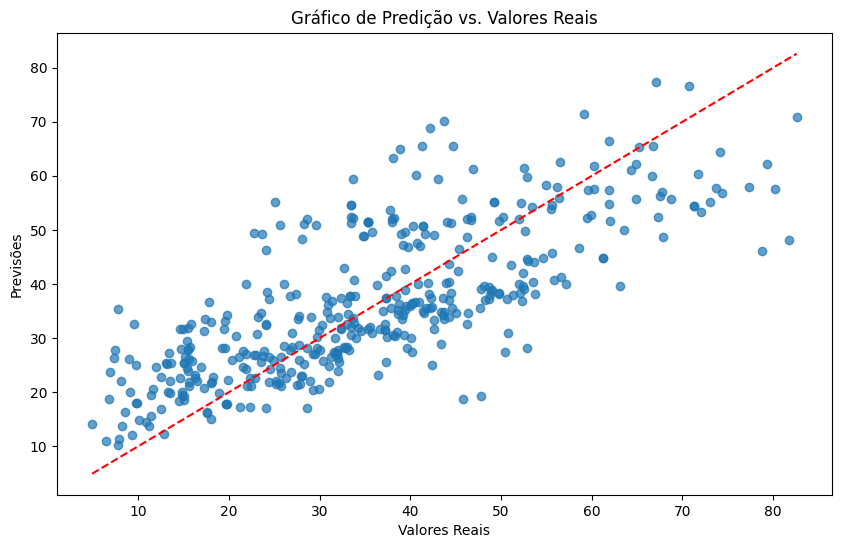

In [23]:
# Gráfico de Predição vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Linha de 45 graus para referência
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("Gráfico de Predição vs. Valores Reais")
plt.show()

Cada ponto representa um par de valor real e predito.
A linha vermelha tracejada de 45 graus representa onde estariam as previsões perfeitas (onde a previsão é exatamente igual ao valor real).
Quanto mais próximos os pontos estiverem dessa linha, melhor o modelo.

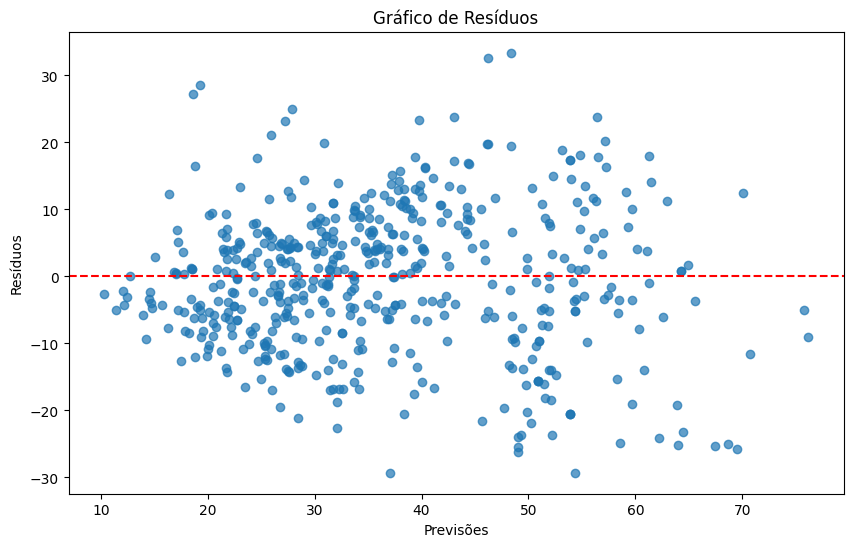

In [27]:
# Gráfico de Resíduos
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Previsões")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos")
plt.show()

Mostra a diferença entre os valores reais e preditos (resíduos) em relação às previsões.
A linha vermelha tracejada em zero representa a posição ideal dos resíduos.
Se os resíduos estão distribuídos aleatoriamente em torno de zero, isso sugere que o modelo não tem tendências e é adequado para os dados.

In [28]:
# Definir os intervalos de tempo de cura para análise
df['age_group'] = pd.cut(df['age'], bins=[0, 7, 28, 56, df['age'].max()], 
                         labels=['0-7 dias', '8-28 dias', '29-56 dias', '57+ dias'])

In [32]:
# Calcular a média de resistência à compressão para cada grupo de tempo de cura
resistencia_media_por_idade = df.groupby('age_group', observed=False)['strength'].mean()

print("\nMédia de resistência à compressão por intervalo de tempo de cura:")
print(resistencia_media_por_idade)


Média de resistência à compressão por intervalo de tempo de cura:
age_group
0-7 dias      22.308397
8-28 dias     35.730431
29-56 dias    51.890220
57+ dias      46.973526
Name: strength, dtype: float64


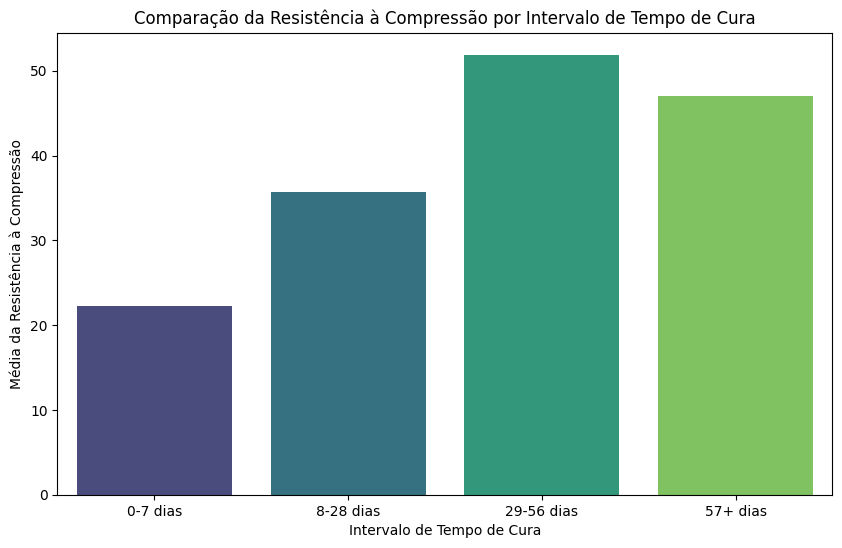

In [31]:
# Plotar o gráfico de barras para visualização
plt.figure(figsize=(10, 6))
sns.barplot(x=resistencia_media_por_idade.index, y=resistencia_media_por_idade.values, palette="viridis", hue=resistencia_media_por_idade.index, legend=False)
plt.xlabel("Intervalo de Tempo de Cura")
plt.ylabel("Média da Resistência à Compressão")
plt.title("Comparação da Resistência à Compressão por Intervalo de Tempo de Cura")
plt.show()

Usamos um gráfico de barras para exibir a resistência média para cada intervalo de tempo de cura. Isso permite uma análise visual clara de como a resistência do concreto tende a aumentar com o tempo de cura.

In [34]:
# Selecionar apenas as colunas de ingredientes e tempo de cura para a clusterização
ingredientes = df[['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age']]

# Padronizar os dados para que todas as variáveis tenham média 0 e desvio padrão 1
scaler = StandardScaler()
ingredientes_scaled = scaler.fit_transform(ingredientes)

In [35]:
# Determinar o número de clusters usando o método Elbow
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ingredientes_scaled)
    inertia.append(kmeans.inertia_)

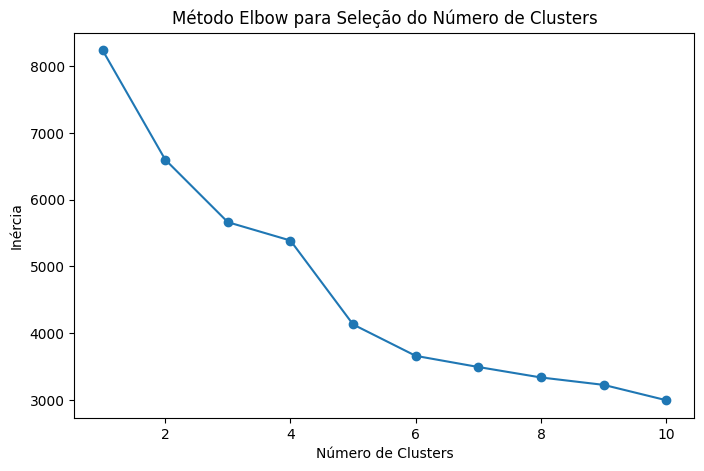

In [36]:
# Plotar o gráfico Elbow para escolher o número ideal de clusters
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método Elbow para Seleção do Número de Clusters')
plt.show()

Calculamos a inércia para diferentes números de clusters e plotamos o gráfico "Elbow". A quantidade ideal de clusters é onde a inércia começa a diminuir lentamente (o "cotovelo" do gráfico).

In [39]:
# Escolher o número ideal de clusters com base no gráfico Elbow
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(ingredientes_scaled)

In [49]:
# Adicionar a coluna de resistência à compressão para análise do cluster
df['strength'] = df['strength']

# Analisar a média dos ingredientes e da resistência por cluster
clusters_analise = df.groupby('Cluster').mean('strength').sort_values('strength')
print("\nMédia das características em cada cluster:")
print(clusters_analise)


Média das características em cada cluster:
             cement        slag         ash       water  superplastic  \
Cluster                                                                 
3        202.313369  190.595722    1.310160  192.317647      2.473262   
2        353.338424    3.261084    0.586207  191.339901      0.351232   
1        220.225000   17.805357  125.393571  168.036071      8.610000   
4        246.173611   89.505556  124.116667  192.570139      8.767361   
0        347.449091   62.696364    0.000000  214.672727      0.000000   
5        396.403106  114.824224   15.322981  159.140994     13.563354   

           coarseagg     fineagg         age   strength  
Cluster                                                  
3         974.184492  754.204813   31.192513  28.885241  
2        1020.366502  769.256158   33.251232  29.561527  
1        1018.593929  806.813571   38.546429  33.587464  
4         878.672917  743.755556   27.250000  34.196319  
0         966.480000  6

Média das Características por Cluster: Essa tabela mostra a média de cada ingrediente e da resistência à compressão em cada cluster. Isso nos ajuda a identificar quais misturas de ingredientes estão associadas a maiores resistências.

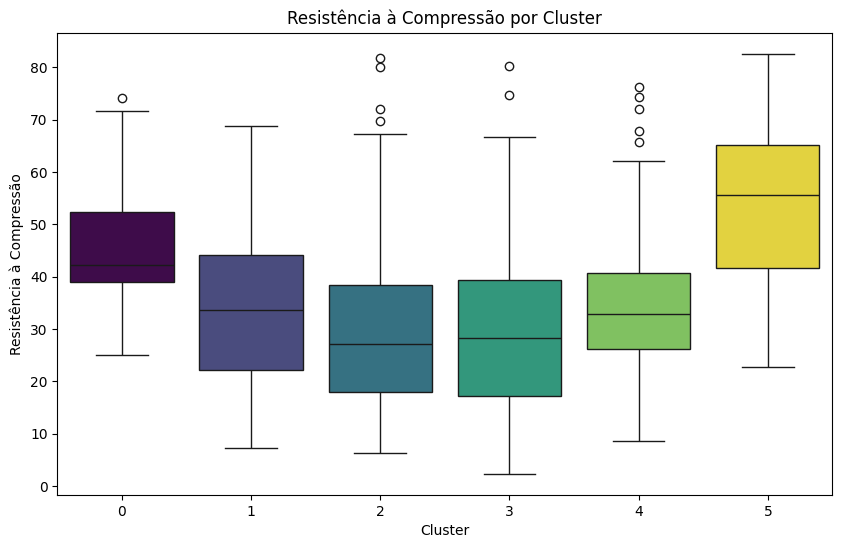

In [52]:
# Visualizar os clusters em relação à resistência à compressão
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='strength', data=df, palette='viridis', hue='Cluster', legend=False)
plt.xlabel("Cluster")
plt.ylabel("Resistência à Compressão")
plt.title("Resistência à Compressão por Cluster")
plt.show()

Gráfico de Resistência por Cluster: O boxplot exibe a distribuição da resistência à compressão em cada cluster, o que permite identificar rapidamente quais grupos têm uma resistência média maior.